<h1> Monte Carlo Portfolio Simulation <h1>

A computational method used in quantitative finance to model the potential future performance of an investment portfolio by simulating thousands of possible market scenarios. It helps estimate expected returns, volatility, and risk measures like Value-at-Risk (VaR) by incorporating randomized price movements based on historical data. The simulation typically assumes that asset prices follow a Geometric Brownian Motion (GBM), where future prices are influenced by historical returns, volatility, and random market shocks. By repeatedly simulating different possible price paths, Monte Carlo analysis allows investors and risk managers to assess the likelihood of different portfolio outcomes under uncertain market conditions. This technique is widely used for risk assessment, portfolio optimization, and stress testing, making it a valuable tool in financial decision-making.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

<h3> Fetching Data <h3>

In [22]:
def retrieve_yahoo_finance_data(stocks, start, end):
  data = yf.download(stocks, start=start, end=end)
  data = data["Close"]
  returns = data.pct_change()
  return returns.mean(), returns.cov()


In [23]:
stocks = ["NVDA", "TSLA", "AAPL"]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1000)

avg_returns, cov_matrix = retrieve_yahoo_finance_data(stocks, start_date, end_date)
print(avg_returns)

[*********************100%***********************]  3 of 3 completed

Ticker
AAPL    0.000924
NVDA    0.003411
TSLA    0.000826
dtype: float64


<h3> Portfolio Weights <h3>

In [26]:
weights = np.random.random(len(avg_returns))
weights /= np.sum(weights)

print(weights)

[0.55463402 0.40122557 0.04414041]


<h3> Simulation <h3>

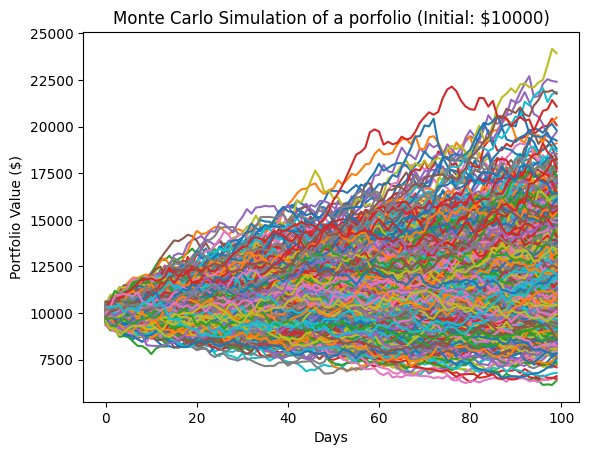

In [27]:
n_simulations = 1000
T = 100 #days

avg_M = np.full(shape=(T, len(weights)), fill_value=avg_returns)
avg_M = avg_M.T

portfolio_sims = np.full(shape=(T, n_simulations), fill_value=0.0)
initial_portfolio = 10000
for n in range(0, n_simulations):
  Z = np.random.normal(size=(T, len(weights)))
  L = np.linalg.cholesky(cov_matrix)
  daily_returns = avg_M + np.inner(L,Z)
  portfolio_sims[:,n] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of a Porfolio (Initial: $10000)")
plt.show()

<h3> VaR <h3>

In [35]:
def mc_VaR(returns, alpha=5):
  # input: pandas series of returns
  # output: percentile on returns distribution to a given confidence alpha
  if(isinstance(returns, pd.Series)):
    return np.percentile(returns, alpha)
  else:
    raise TypeError("Expected a pandas data series")
  

In [36]:
def mc_CVaR(returns, alpha = 5):
  # input: pandas series of returns
  # output: CVar or expected shortfall to a given confidence alpha
  if(isinstance(returns, pd.Series)):
    below_VaR = returns <= mc_VaR(returns, alpha = alpha)
    return returns[below_VaR].mean()
  else:
    raise TypeError("Expected a pandas data series")


In [37]:
portfolio_results = pd.Series(portfolio_sims[-1,:])
VaR = initial_portfolio - mc_VaR(portfolio_results, alpha = 5)
CVaR = initial_portfolio - mc_CVaR(portfolio_results, alpha = 5)

print("VaR ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))

VaR $1422.2
CVaR $2091.35
